# Imports + GPU Setup

In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
import logging
import re
import nltk
import torch.nn.functional as F
import torch.optim as optim

from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from copy import deepcopy
from urllib import request
from dont_patronize_me import DontPatronizeMe # data manager module
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from transformers import RobertaModel, RobertaTokenizer

logging.basicConfig(level=logging.ERROR)
nltk.download('punkt')
nltk.download('stopwords')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


[nltk_data] Downloading package punkt to /homes/grm23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /homes/grm23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Setup

Retrieves the data, applies the specified train and test split to organise data into **train_df** and **dev_df**.

In [69]:
# Download data

module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# Init data manager module

dpm = DontPatronizeMe('./data', './data/task4_test.tsv')
dpm.load_task1()

# Train and test splits

train_ids = pd.read_csv('./data/train_semeval_parids-labels.csv')
test_ids = pd.read_csv('./data/dev_semeval_parids-labels.csv')

train_ids.par_id = train_ids.par_id.astype(str)
test_ids.par_id = test_ids.par_id.astype(str)

data=dpm.train_task1_df

rows = [] # will contain par_id, label and text
for idx in range(len(train_ids)):
  id = train_ids.par_id[idx]
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == id].keyword.values[0]
  text = data.loc[data.par_id == id].text.values[0]
  label = data.loc[data.par_id == id].label.values[0]
  country = data.loc[data.par_id == id].country.values[0]
  
  rows.append({
      'par_id':id,
      'keyword':keyword,
      'text':text,
      'country':country,
      'label':label
  })

train_df = pd.DataFrame(rows)

# downsample negative instances
pcldf = train_df[train_df.label==1]
npos = len(pcldf)
balanced_train_df = pd.concat([pcldf, train_df[train_df.label==0][:int(2.5*npos)]])
balanced_train_df = balanced_train_df[['text', 'keyword', 'label', 'country']]

## BUILD DEV (TEST) DATASET ##

rows = [] # will contain par_id, label and text
for idx in range(len(test_ids)):
  parid = test_ids.par_id[idx]
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  country = data.loc[data.par_id == parid].country.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'keyword':keyword,
      'text':text,
      'country':country,
      'label':label
  })

dev_df = pd.DataFrame(rows)

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


# Preprocessing Functions

In [3]:
def clean_text(text: str, whitespacing = True, standard_tokens = True, punctuation=True, stop_words = False,lower=False) -> str:

        stop_words = stopwords.words("english")
        
        if stop_words:
            # Stop words --> token
            words = word_tokenize(text)
            words = [word for word in words if word not in stopwords.words("english") and word.isalpha()]
            text = " ".join(words)

        if lower:
             text=text.lower()

        if whitespacing:
            # Whtespacing and other standarisation
            text = text.strip('"')  # removing " at start of sentences
            text = re.sub(r'\s+', ' ', text)
            text = re.sub('<h>', '.', text)

        if standard_tokens:
            # Removing unecessary info
            text = re.sub("(?<![\w])[0-9]+[.,]?[0-9]*(?![\w])", "[NUM]", text)
            text = re.sub("\[NUM\]-\[NUM\]", "[NUM]", text)
            # To delete account numbers 12-5223-231
            text = re.sub("\[NUM\]-\[NUM\]", "[NUM]", text)
            text = re.sub(r"https? : \S+", "[WEBSITE]", text)  # Tokenize links
            text = re.sub("(?<![\w])20[0-5][0-9]-?[0-9]*", "[YEAR]", text)  # Year token
            text = re.sub(r"@[\S]+", "[USERNAME]", text)  # removing referencing on usernames with @
            text = re.sub("(?<![\w])1[0-9]{3}-?[0-9]*", "[YEAR]", text)  # Year token
            #text = re.sub("(?<=\[NUM\])-(?=[a-zA-Z])", " ", text)

        if punctuation:
            text = re.sub(r":\S+", "", text)  # removing smileys with : (like :),:D,:( etc)
            text = re.sub(r"\"+", "", text)  # replacing repetitions of punctations
            text = re.sub(r"(\W)(?=\1)", "", text)  # replacing repetitions of punctations
            
        return text.strip()

In [4]:
def ohc_row(df, col):
    """
    OHC a col of data (used for ohc the country column) and 
    remove the col 
    """
    ohc_df = df.copy()
    # OHC the country labels 
    one_hot_encoding = pd.get_dummies(ohc_df[col], prefix=col, dtype=float)
    # Add OHC labels
    ohc_df = ohc_df.join(one_hot_encoding)
    # Drop old column
    ohc_df = ohc_df.drop('country', axis=1)
    # Return OHC df
    return ohc_df


balanced_train_df_ohc = ohc_row(balanced_train_df, 'country')
dev_df_ohc = ohc_row(dev_df, 'country')

# Dataset

In [80]:
class DPMDataset(Dataset):
    """
    Dataset for regular use with Roberta/Deberta
    
    """

    def __init__(self, df, tokenizer, max_len, test_set=False):
        
        self.test_set = test_set
        self.tokenizer = tokenizer
        self.text = df.text

        if not test_set:
            self.label = df.label

        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):

        if not self.test_set:
            return {
                'text': self.text[idx],
                'target': self.label[idx]
            }
        else:
            return {
                'text': self.text[idx],
            }


    def collate_fn(self, batch):
        texts = []
        labels = []


        for b in batch:
            texts.append(b['text'])
            if not self.test_set:
                labels.append(b['target'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        if not self.test_set:
            encodings['target'] = torch.tensor(labels)

        return encodings

In [6]:
class DPMDataset2(Dataset):
    """
    Dataset that includes country for an additional input to the classification head
    """

    def __init__(self, df, tokenizer, max_len):

        self.tokenizer = tokenizer
        self.text = df.text
        self.label = df.label

        ohc_columns = df.filter(like='country_').columns # extract ohc columns
        self.country = df[ohc_columns]

        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):

        return {
            'text': self.text[idx],
            'country': np.array(self.country.iloc[idx]),
            'target': self.label[idx]
        }

    def collate_fn(self, batch):
        texts = []
        countries = []
        labels = []
    

        for b in batch:

            texts.append(b['text'])
            countries.append(b['country'])
            labels.append(b['target'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        encodings['countries'] = torch.tensor(countries, dtype=torch.int64)
        encodings['target'] = torch.tensor(labels)

        return encodings

# Data Augmentation

Function to apply augmentation to text and specify the type of augmentation to perform

In [16]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

def augmenter (text, deletion=False, Synonym=False, Spelling=False, CWE=False):

    augmented_texts=text

    if Spelling:
        aug = naw.SpellingAug()
        augmented_texts = aug.augment(augmented_texts, n=3)
        
    if deletion:
        aug = naw.RandomWordAug(action="delete")
        augmented_texts = aug.augment(augmented_texts)

    if Synonym:
        aug = naw.SynonymAug(aug_src='wordnet')
        augmented_texts = aug.augment(augmented_texts)
    
    if CWE:
        aug = naw.ContextualWordEmbsAug(
            model_path = 'distilbert-base-uncased', 
            device = device,
            action = "substitute",
            top_k = 20
        )
        augmented_texts = aug.augment(text)
        
    return augmented_texts[0]

# Models

In [7]:
from transformers import RobertaPreTrainedModel, TrainingArguments, DebertaModel

class JoBert(RobertaPreTrainedModel):
    """
    Implementation of Roberta with a classifier head 
    """
    def __init__(self,config):
        super().__init__(config)

        self.roberta=RobertaModel(config)
        # self.deberta = DebertaModel(config)
        self.projection =torch.nn.Sequential (torch.nn.Dropout(0.2),torch.nn.Linear(config.hidden_size,2))

        self.init_weights()

    def forward(

        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        target=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        # outputs = self.deberta(
        #     input_ids,
        #     attention_mask=attention_mask,
        #     token_type_ids=token_type_ids,
        #     position_ids=position_ids,
        #     inputs_embeds=inputs_embeds,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=False
        # )
        logits = self.projection(outputs[1])
        return logits


In [8]:
from transformers import RobertaPreTrainedModel, TrainingArguments, DebertaModel,DebertaPreTrainedModel

class DebertaClassification(DebertaPreTrainedModel):
    """
    Implementation of Deberta with a classifier head
    """
    def __init__(self,config):

        super().__init__(config)

        # self.roberta=RobertaModel(config)
        self.deberta = DebertaModel(config)
        self.pooling = torch.nn.AdaptiveMaxPool1d(1)  # Global Max Pooling

        self.projection =torch.nn.Sequential (torch.nn.Dropout(0.2),torch.nn.Linear(config.hidden_size,2))

        self.init_weights()

    def forward(

        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        target=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):

        # outputs = self.roberta(
        #     input_ids,
        #     attention_mask=attention_mask,
        #     token_type_ids=token_type_ids,
        #     position_ids=position_ids,
        #     head_mask=head_mask,
        #     inputs_embeds=inputs_embeds,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )
        
        deberta_output = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )[0]
        deberta_output_permuted = deberta_output.permute(0, 2, 1)  # Change the shape for pooling
        pooled_output = self.pooling(deberta_output_permuted).squeeze(-1)  # Apply pooling
        logits = self.projection(pooled_output)  # Projection layer
        # print(outputs['last_hidden_state'].shape)
        # logits = self.projection(outputs['last_hidden_state'][-1])
        return logits


In [9]:
class DebertaClassification2(DebertaPreTrainedModel):
    """
    Implementation of Deberta for classification where the classification head takes
    word embeddings and the country which the text came from.
    
    """
    def __init__(self,config):

        super().__init__(config)

        # self.roberta=RobertaModel(config)
        self.deberta = DebertaModel(config)
        self.pooling = torch.nn.AdaptiveMaxPool1d(1)  # Global Max Pooling

        # Input to the linear layer is the Deberta hidden size + 20 for country OHC
        self.projection = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                             torch.nn.Linear(config.hidden_size+20,2)) 

        self.init_weights()

    def forward(

        self,
        input_ids=None,
        countries=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        target=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):

        # outputs = self.roberta(
        #     input_ids,
        #     attention_mask=attention_mask,
        #     token_type_ids=token_type_ids,
        #     position_ids=position_ids,
        #     head_mask=head_mask,
        #     inputs_embeds=inputs_embeds,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )
        
        deberta_output = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )[0]
        deberta_output_permuted = deberta_output.permute(0, 2, 1)  # Change the shape for pooling
        pooled_output = self.pooling(deberta_output_permuted).squeeze(-1)  # Apply pooling

        conact_output = torch.concat([pooled_output, countries], dim=1) # concat the pooled output + ohc countires
        logits = self.projection(conact_output)  # Projection layer
      
        return logits


# Training Loop

In [10]:
## TRAINING LOOP FOR ROBERTA (MOSTLY SAME AS DEBERTA -> JUST A BACKUP INCASE WE BREAK ANYTHING!)

from transformers import Trainer, TrainingArguments, DebertaTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Custom Training Functions
class Trainer_PCL(Trainer):

    def __init__( 
        self,
        **kwargs
        ):

        super().__init__(**kwargs)
        
        self.epoch = 1
        self.results = {}


    def compute_loss(self, model, inputs):

        outputs = model(**inputs)

        loss_fn = nn.CrossEntropyLoss()
        target = inputs['target']
        loss = loss_fn(outputs.view(-1, 2), target.view(-1))
        return loss
    
    # Custom Evaluation 
    def evaluate(self, evaluate_datset=None, ignore_keys=None, metric_key_prefix='eval'):
  
        preds = []
        labels = []

        eval_dataloader = super().get_test_dataloader(self.eval_dataset)
        self.model.eval()
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                
                output = self.model(**data)
                pred = torch.max(output, 1)[1]
            
                preds.extend(pred.cpu().tolist())
                labels.extend(data['target'].cpu().tolist())

        # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
        metrics = compute_metrics((preds, labels))
        print(metrics)

        self.results[self.epoch] = metrics
        self.epoch += 1       

            
def compute_metrics(eval_pred):

    preds, labels = eval_pred

    report = classification_report(preds, labels, target_names=["Not PCL","PCL"], output_dict= True) 

    return {"f1": report['PCL']['f1-score'],
            "precision": report['PCL']['precision'],
            "recall": report['PCL']['recall']
            }

def train(model, data, num_epochs, lr=0.0001, optimizer=None, lr_scheduler=None):
    
    train_data, eval_data = train_test_split(data, test_size=0.2, random_state=1)

    # Reset the index for the training DataFrame
    train_data = train_data.reset_index(drop=True)
    # Reset the index for the evaluation DataFrame
    eval_data = eval_data.reset_index(drop=True)
    
    # tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')


    train_dataset = DPMDataset(train_data, tokenizer, max_len=128)
    eval_dataset = DPMDataset(eval_data, tokenizer, max_len=128)

    Training_args = TrainingArguments(output_dir="test_trainer",
                                    learning_rate=lr,
                                    logging_steps=100,
                                    per_device_train_batch_size=50,
                                    num_train_epochs=num_epochs,
                                    remove_unused_columns=False,
                                    logging_dir='./logs', 
                                    evaluation_strategy="epoch"
                                    )
    
    trainer = Trainer_PCL(
        model = model,
        args = Training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        data_collator= train_dataset.collate_fn,
        optimizers = (optimizer, lr_scheduler),
    )

    trainer.train()
    trainer.save_model('roberta-finetuned')
    return trainer.results

2024-03-03 00:07:28.205671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 00:07:28.205771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 00:07:28.267229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 00:07:28.394171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 00:07:31.239637: W tensorflow/compiler/tf2

In [15]:
# TRAINING LOOP FOR TRAINING DEBERTA 
from transformers import Trainer, TrainingArguments, DebertaTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Custom Training Functions
class Trainer_PCL(Trainer):

    def __init__( 
        self,
        **kwargs
        ):

        super().__init__(**kwargs)
        
        self.epoch = 1
        self.results = {}


    def compute_loss(self, model, inputs):
        
        outputs = model(**inputs)

        loss_fn = nn.CrossEntropyLoss()
        target = inputs['target']
        loss = loss_fn(outputs.view(-1, 2), target.view(-1))
        return loss
    
    # Custom Evaluation 
    def evaluate(self, evaluate_datset=None, ignore_keys=None, metric_key_prefix='eval'):
        
        if self.epoch < 10:
            self.epoch+=1
            return
        preds = []
        labels = []

        eval_dataloader = super().get_test_dataloader(self.eval_dataset)
        self.model.eval()
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                
                output = self.model(**data)
                pred = torch.max(output, 1)[1]
            
                preds.extend(pred.cpu().tolist())
                labels.extend(data['target'].cpu().tolist())

        # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
        metrics = compute_metrics((preds, labels))
        print(metrics)

        self.results[self.epoch] = metrics
        self.epoch += 1       

            
def compute_metrics(eval_pred):

    preds, labels = eval_pred

    report = classification_report(preds, labels, target_names=["Not PCL","PCL"], output_dict= True) 

    return {"f1": report['PCL']['f1-score'],
            "precision": report['PCL']['precision'],
            "recall": report['PCL']['recall']
            }

def train(model, data, num_epochs, lr=0.0001, optimizer=None, lr_scheduler=None):
    
 #   train_data, eval_data = train_test_split(data, test_size=0.2, random_state=1)

    # Reset the index for the training DataFrame
    data = data.reset_index(drop=True)
    # Reset the index for the evaluation DataFrame
  #  eval_data = eval_data.reset_index(drop=True)
    
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    train_dataset = DPMDataset(data, tokenizer, max_len=128)
   # eval_dataset = DPMDataset2(eval_data, tokenizer, max_len=128)

    Training_args = TrainingArguments(output_dir="test_trainer",
                                    learning_rate=lr,
                                    logging_steps=100,
                                    per_device_train_batch_size=8,
                                    num_train_epochs=num_epochs,
                                    remove_unused_columns=False,
                                    logging_dir='./logs', 
                                 #   evaluation_strategy="epoch"
                                    )
    
    trainer = Trainer_PCL(
        model = model,
        args = Training_args,
        train_dataset = train_dataset,
       # eval_dataset = eval_dataset,
        data_collator= train_dataset.collate_fn,
        optimizers = (optimizer, lr_scheduler),
    )

    trainer.train()
    trainer.save_model('deberta-finetuned')
    return trainer.results

In [77]:
# Code for evaluating model performance 
def predict_PCL(input, tokenizer, model, country=None):
  
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  if country is not None:
    encodings['countries'] = country
  
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader, score=True):

  preds = []
  tot_labels = []

  with torch.no_grad():
    
    for data in tqdm(data_loader):

      text = data['text']
      # country = data['country'].float()
      pred = predict_PCL(text, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      if score:
        tot_labels.append(data['target'].tolist())

  if score:
    # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
    print(classification_report(tot_labels, preds, target_names=["Not PCL","PCL"]))

  return preds


# Applying Preprocessing + Data Augmentation

In [12]:
# Applies preprocessing from clean_text

preprocessed_train_df = balanced_train_df.copy(deep=True)
preprocessed_train_df['text'] = preprocessed_train_df['text'].apply(lambda x: clean_text(x, whitespacing=False, standard_tokens=True,
                                                                                         punctuation=True, stop_words=True, lower=False))


KeyboardInterrupt: 

In [18]:
augmented_train_df = balanced_train_df.copy(deep=True)

augmented_rows = []

for index, row in augmented_train_df.iterrows():
    if row['label'] == 0:
        continue
    else:
        # Apply the augmenter function to the 'text' column
        augmented_text = augmenter(row['text'], deletion=False, Synonym=True, Spelling=False, CWE=True)
        # Create a new row with the augmented text
        augmented_row = row.copy()
        augmented_row['text'] = augmented_text
        
        # Append the new row to the list
        augmented_rows.append(augmented_row)

# Convert the list of augmented rows to a DataFrame
augmented_rows_df = pd.DataFrame(augmented_rows)

# Append the new DataFrame to the original DataFrame
augmented_train_df = pd.concat([augmented_train_df, augmented_rows_df])

# TRAINING

In [19]:
# model = JoBert.from_pretrained('FacebookAI/roberta-base').to(device)
model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)

lr = 1e-5
#optimizer = optim.AdamW(model.parameters(), lr)
optimizer = optim.AdamW(model.parameters(), lr)
lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
results = train(model, augmented_train_df, num_epochs= 10, lr=lr, optimizer=optimizer, lr_scheduler=lrs)

Some weights of DebertaClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['projection.1.bias', 'projection.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grm23 (mavro). Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.678400
200,0.478200
300,0.461500
400,0.351600
500,0.359000
600,0.310800
700,0.380100
800,0.421400
900,0.265900
1000,0.243700


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test_trainer/checkpoint-3500 already exists and is non-empty. Saving will 

In [22]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 128)
test_loader = DataLoader(test_dataset, shuffle=False)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████| 2094/2094 [03:14<00:00, 10.77it/s]

              precision    recall  f1-score   support

     Not PCL       0.97      0.91      0.94      1895
         PCL       0.46      0.69      0.55       199

    accuracy                           0.89      2094
   macro avg       0.71      0.80      0.74      2094
weighted avg       0.92      0.89      0.90      2094



In [61]:
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [62]:
labels2file([k for k in preds], 'dev.txt')

# Baseline Model Experiementation

In [28]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Sample dataset
X_train = augmented_train_df['text']
y_train = augmented_train_df['label']  

X_dev = dev_df['text']
y_dev = dev_df['label']

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(strip_accents='ascii', stop_words=None, ngram_range=(2,2))

# Fit and transform the text data to numerical vectors
X_train = vectorizer.fit_transform(X_train)
X_dev = vectorizer.transform(X_dev)

lr = LogisticRegression(random_state=1)
dt = DecisionTreeClassifier(random_state=1)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

lr_pred = lr.predict(X_dev)
dt_pred = dt.predict(X_dev)


print("Decision Tree:\n", classification_report(y_dev, dt_pred, target_names=["Not PCL","PCL"]))
print("LogisticRegression:\n", classification_report(y_dev, lr_pred, target_names=["Not PCL","PCL"]))

Decision Tree:
               precision    recall  f1-score   support

     Not PCL       0.93      0.83      0.88      1895
         PCL       0.21      0.44      0.28       199

    accuracy                           0.79      2094
   macro avg       0.57      0.63      0.58      2094
weighted avg       0.86      0.79      0.82      2094

LogisticRegression:
               precision    recall  f1-score   support

     Not PCL       0.93      0.91      0.92      1895
         PCL       0.31      0.39      0.35       199

    accuracy                           0.86      2094
   macro avg       0.62      0.65      0.63      2094
weighted avg       0.88      0.86      0.87      2094



# Model evaluation, plots, experimentation, etc...

In [75]:
# load the test file
dpm.load_test()

test_df = dpm.test_set_df

In [81]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(test_df, tokenizer, 128, test_set=True)
test_loader = DataLoader(test_dataset, shuffle=False)

preds = evaluate(model, tokenizer, test_loader, score=False)

100%|██████████| 3832/3832 [05:21<00:00, 11.91it/s]


In [89]:
labels2file([k for k in preds], 'text.txt')

In [30]:
deberta_preds = np.array(preds).flatten()

# gets false negative, false positive, true postive, true negative from dataframes
deberta_fn = dev_df[(dev_df['label'] == 1) & (np.array(deberta_preds) == 0)]
deberta_fp = dev_df[(dev_df['label'] == 0) & (np.array(deberta_preds) == 1)]
deberta_tp = dev_df[(dev_df['label'] == 1) & (np.array(deberta_preds) == 1)]
deberta_tn = dev_df[(dev_df['label'] == 0) & (np.array(deberta_preds) == 0)]

deberta_correct = pd.concat([deberta_tp, deberta_tn], axis=0)
deberta_incorrect = pd.concat([deberta_fn, deberta_fp], axis=0)
deberta_correct['text_length'] = deberta_correct['text'].str.split().str.len()
deberta_incorrect['text_length'] = deberta_incorrect['text'].str.split().str.len()

# merge to the original 'data' set 
data_fn = data[data['par_id'].isin(deberta_fn['par_id'])]
data_fn['text_length'] = data_fn['text'].str.split().str.len()
data_fp = data[data['par_id'].isin(deberta_fp['par_id'])]
data_fp['text_length'] = data_fp['text'].str.split().str.len()

# countires and keywords for plotting
countries = data['country'].to_list()
keywords = data['keyword'].to_list()

/tmp/ipykernel_526183/1407958860.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fn['text_length'] = data_fn['text'].str.split().str.len()
/tmp/ipykernel_526183/1407958860.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['text_length'] = data_fp['text'].str.split().str.len()


In [54]:
# data that the decision tree predicted wrong but deberta predicted corrected

missed_df = dev_df[(dev_df['label'] == 1) & (np.array(dt_pred) == 0) & (dev_df['par_id'].isin(deberta_tp['par_id']))]

missed_df.sample(1)['text'].iloc[0]

'Hollywood star Leo Di Caprio urges help for reuniting immigrant children with their families'

In [471]:
print(f'Correct mean =', deberta_correct['text_length'].mean())
print('Correct median =', deberta_correct['text_length'].median())

print(f'Incorrect mean = ', deberta_incorrect['text_length'].mean())
print('Incorrect median = ', deberta_incorrect['text_length'].median())


Correct mean = 46.78146759507231
Correct median = 41.0
Incorrect mean =  52.59471365638767
Incorrect median =  46.0


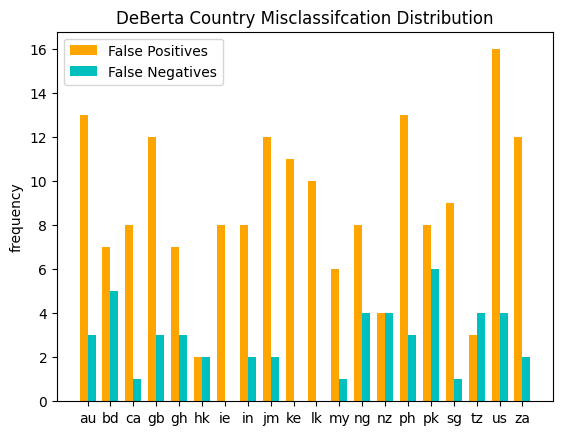

In [390]:
import matplotlib.pyplot as plt

def plot_data(fp_df, fn_df, categories, category_name, title):

    fp_counts = fp_df[category_name].value_counts().to_dict()
    fn_counts = fn_df[category_name].value_counts().to_dict()

    for category in categories:
        if category not in fp_counts:
            fp_counts[category] = 0
        if category not in fn_counts:
            fn_counts[category] = 0

    fp_counts = sorted(fp_counts.items(), key=lambda x: x[0])
    fn_counts = sorted(fn_counts.items(), key=lambda x: x[0])

    categories = [x[0] for x in fp_counts]
    fp_counts = [x[1] for x in fp_counts]
    fn_counts = [x[1] for x in fn_counts]

    ind = np.arange(len(categories))
    width = 0.35

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.bar(ind - width/2, fp_counts, width, label='False Positives', color='orange')

    ax.bar(ind + width/2, fn_counts, width, label='False Negatives', color='c')

    ax.set_ylabel('frequency')
    ax.set_title(title)
    ax.set_xticks(ind)
    if category_name == 'keyword':
        ax.tick_params(rotation=45)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(fp_df=deberta_fp, fn_df=deberta_fn, categories=countries, category_name='country', title='DeBerta Country Misclassifcation Distribution')

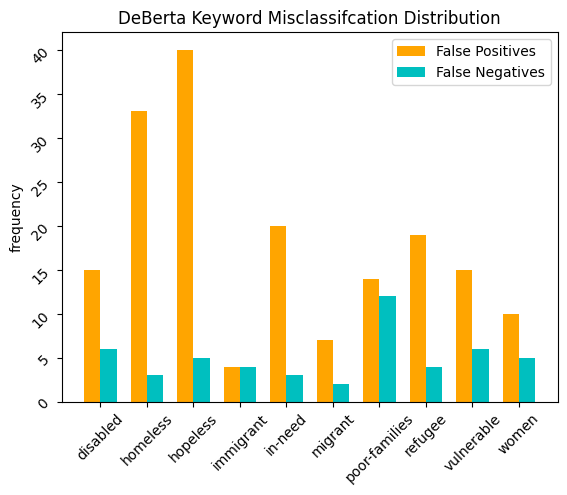

In [391]:
plot_data(fp_df=deberta_fp, fn_df=deberta_fn, categories=keywords, category_name='keyword', title='DeBerta Keyword Misclassifcation Distribution')

In [410]:
data_fn.value_counts('orig_label')

orig_label
3    30
2    11
4     9
Name: count, dtype: int64

In [411]:
data_fp.value_counts('orig_label')

orig_label
0    117
1     60
Name: count, dtype: int64

In [413]:
dev_data_df = data[data['par_id'].isin(dev_df['par_id'])]
dev_data_df.value_counts('orig_label')

orig_label
0    1704
1     191
4      92
3      89
2      18
Name: count, dtype: int64